In [1]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from argparse import Namespace

from sklearn.decomposition import PCA

from maskrcnn.postprocess.validate import L, gini, plot_scatter
from maskrcnn.postprocess.polygonize import load_anns

from scipy.spatial.distance import cdist

import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [22]:
def n_neighbor(coords, h):
    return (cdist(coords, coords, 'euclidean') < h).sum(axis=0).mean()

def diff(x):
    return np.max(x) - np.min(x)

In [3]:
# image index data
IDX_IN_DIR = 'data/Experiment3/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment3/aoi_download_log.csv'

# census data
CEN_IN_DIR = 'data/Experiment3/census.shp'

# satellite derived data
SAT_IN_ANN_DIR = 'data/MexicoInequality/Pred/infer/'
SAT_IN_IMG_DIR = 'data/MexicoInequality/Image/'
SAT_IN_SHP_DIR = 'data/Experiment3/sat.shp'

# output path
OUT_DIR = 'data/Experiment3/Output/'

In [4]:
# read image index data frame
df_idx = pd.merge(pd.read_csv(IDX_IN_DIR), pd.read_csv(LOG_IN_DIR),
                  how='outer', on='index')
df_idx = df_idx.loc[:, ['index', 'ent', 'mun', 'loc', 'chip',
                        'status', 'lon_min', 'lon_max', 'lat_min', 'lat_max']]

In [5]:
assert (df_idx['status'] == False).sum() == 0  # no missing

In [6]:
# read census data
df_cen = gpd.read_file(CEN_IN_DIR)

In [7]:
if os.path.isfile(SAT_IN_SHP_DIR):
    df_sat = gpd.read_file(SAT_IN_SHP_DIR)
else:
    # read sat annotations
    ann_files = glob.glob(SAT_IN_ANN_DIR + '*.json')
    img_files = [os.path.join(SAT_IN_IMG_DIR,
                              (os.path.relpath(f, SAT_IN_ANN_DIR).replace('.json', '.png')))
                 for f in ann_files]
    df_sat = load_anns(ann_files=ann_files,
                       img_files=img_files,
                       idx_file=IDX_IN_DIR)
    df_sat = pd.concat([
        df_sat.reset_index(drop=True),
        pd.DataFrame(df_sat.loc[:, 'RGB_mean'].tolist(),
                     columns=['R_mean', 'G_mean', 'B_mean'])], axis=1)
    df_sat = pd.merge(df_sat, df_idx, how='left', on='index')
    df_sat = df_sat.drop(columns=['RGB_mean'])
    df_sat.to_file(SAT_IN_SHP_DIR, index=False)

In [19]:
# grouping into localities
df_group = df_sat.drop(columns=['geometry']).groupby(['ent', 'mun', 'loc']).agg(
    sat_house=pd.NamedAgg(column='area', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
#     sat_size_med=pd.NamedAgg(column='area', aggfunc=np.nanmedian),  # nah not better than mean
    sat_lum_mean=pd.NamedAgg(column='luminosity', aggfunc=np.nanmean),
    sat_saturation_mean=pd.NamedAgg(column='saturation', aggfunc=np.nanmean),
#     sat_size_gini=pd.NamedAgg(column='area', aggfunc=gini_series),  # no signal
    sat_size_sum=pd.NamedAgg(column='area', aggfunc=np.nansum)
)

# measure spatial clustering
tile_size = 1.6516e-3

for i, col in zip([.3, .53],
                  ['sat_nn_h30', 'sat_nn_h53']):
    df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
        lambda grp: n_neighbor(
            np.array([grp.centroid.x.values, grp.centroid.y.values]).T,
            h=tile_size * i))

# calculate K function values
# tile_size = 1.6516e-3
# for i, col in zip([.5, 1, 1.5],
#                   ['sat_dist_h05', 'sat_dist_h10', 'sat_dist_h15']):
#     df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
#         lambda grp: L(grp[['lon_center', 'lat_center']].values,
#                       A=(tile_size ** 2) * 25, h=tile_size * i))

# scale areas / distances
df_group[['sat_size_mean', 'sat_size_sum']] *= (
    ((tile_size / 800 * 111000) ** 2) * np.cos(23 / 180 * np.pi))  # in sq meters

df_group['sat_angle_align'] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
    lambda grp: np.sort(np.histogram(
        grp['angle'].values,
        bins=9, range=(0, 90), density=True)[0] * 10)[-3:].sum())

In [20]:
# merge satellite and census
df_group = pd.merge(
    df_group,
    df_cen,
    how='right', on=['ent', 'mun', 'loc'])

In [23]:
df_group

,ent,mun,loc,sat_house,sat_size_mean,sat_lum_mean,sat_saturation_mean,sat_size_sum,sat_nn_h30,sat_nn_h53,...,VPH_TELEF,VPH_CEL,VPH_INTER,TAM_LOC,lon,lat,cen_asset,diff,pair_id,geometry
0,7,89,991,1378,95.958288,0.727996,0.089691,132230.520355,15.625544,43.664731,...,0.004053,0.749855,0.015055,6,-92.307778,14.869722,-0.345134,-0.420889,36,"POLYGON ((-92.30874 14.86403, -92.30933 14.864..."
1,7,89,1025,1378,95.958288,0.727996,0.089691,132230.520355,15.625544,43.664731,...,0.003390,0.879096,0.025989,5,-92.299722,14.865833,0.075755,0.420889,36,"POLYGON ((-92.30593 14.87218, -92.30559 14.871..."
2,13,51,4,848,126.754564,0.677869,0.098949,107487.869929,7.066038,17.033019,...,0.552632,0.822368,0.377193,4,-98.705278,20.090000,-0.769714,-0.182564,234,"POLYGON ((-98.69741 20.09260, -98.69703 20.092..."
3,13,51,10,566,114.031083,0.688820,0.074048,64541.593154,5.120141,11.893993,...,0.239171,0.672316,0.069680,4,-98.697778,20.111944,-0.169120,0.120742,224,"POLYGON ((-98.69842 20.11556, -98.69835 20.115..."
4,13,51,14,755,137.834118,0.699078,0.073804,104064.759250,5.866225,14.949669,...,0.330311,0.805699,0.193005,5,-98.737222,20.076944,-0.547897,0.507999,163,"POLYGON ((-98.74020 20.07517, -98.74068 20.075..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,30,193,223,191,85.644114,0.593348,0.114493,16358.025682,5.303665,13.104712,...,0.204082,0.916593,0.121562,5,-96.220000,19.207778,-0.506469,-0.702292,85,"POLYGON ((-96.21777 19.21212, -96.21766 19.212..."
154,30,193,223,191,85.644114,0.593348,0.114493,16358.025682,5.303665,13.104712,...,0.204082,0.916593,0.121562,5,-96.220000,19.207778,-0.506469,0.037108,89,"POLYGON ((-96.21777 19.21212, -96.21766 19.212..."
155,30,193,231,317,72.550823,0.583858,0.114563,22998.610967,5.618297,13.340694,...,0.241468,0.945911,0.208628,5,-96.211389,19.201944,-0.711307,-0.907130,86,"POLYGON ((-96.21111 19.20534, -96.21063 19.205..."
156,30,193,231,317,72.550823,0.583858,0.114563,22998.610967,5.618297,13.340694,...,0.241468,0.945911,0.208628,5,-96.211389,19.201944,-0.711307,-0.167730,90,"POLYGON ((-96.21111 19.20534, -96.21063 19.205..."


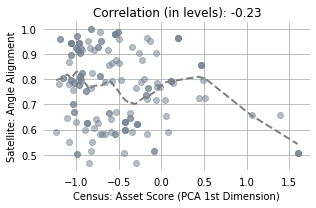

In [21]:
plot_scatter(
    col_x_key='cen_asset',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    col_y_key='sat_angle_align',
    col_y_label='Satellite: Angle Alignment',
    line=True, df=df_group,
    out_dir=OUT_DIR, show=True)

In [24]:
df_group.columns

Index(['ent', 'mun', 'loc', 'sat_house', 'sat_size_mean', 'sat_lum_mean',
       'sat_saturation_mean', 'sat_size_sum', 'sat_nn_h30', 'sat_nn_h53',
       'sat_angle_align', 'NOM_LOC', 'LONGITUD', 'LATITUD', 'POBTOT', 'VIVTOT',
       'TVIVHAB', 'VPH_PISODT', 'VPH_PISOTI', 'VPH_1DOR', 'VPH_2YMASD',
       'VPH_1CUART', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_C_ELEC', 'VPH_S_ELEC',
       'VPH_AGUADV', 'VPH_AGUAFV', 'VPH_EXCSA', 'VPH_DRENAJ', 'VPH_NODREN',
       'VPH_C_SERV', 'VPH_SNBIEN', 'VPH_RADIO', 'VPH_TV', 'VPH_REFRI',
       'VPH_LAVAD', 'VPH_AUTOM', 'VPH_PC', 'VPH_TELEF', 'VPH_CEL', 'VPH_INTER',
       'TAM_LOC', 'lon', 'lat', 'cen_asset', 'diff', 'pair_id', 'geometry'],
      dtype='object')